# DTSA-5511 Deep Learning - Week 4 Kaggle Project
## Natural Language Processing with Disaster Tweets
### https://www.kaggle.com/c/nlp-getting-started/overview

This week's Kaggle challenge will detect from a tweet if it is disaster related.
Competition Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

We will use a Recurrent Neural network (RNN) based for processing texts `keras-nlp` for this problem.
Data files have been copied to personal google drive from Kaggle. We will copy it into colab directory and unzip the contents.

In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import keras.utils
print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompati

### Copy the data files from google drive in colab

In [ ]:
# Complete path to storage location of the .zip file of data
# Mount google drive
import os
from google.colab import drive
drive.mount('/gdrive')

zip_path = '/gdrive/MyDrive/kaggle/nlp-getting-started.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
print(os.getcwd())
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly
!unzip -q 'nlp-getting-started.zip'
# View the unzipped contents in the virtual machine
os.listdir()

Mounted at /gdrive
/content


['.config',
 'train.csv',
 'nlp-getting-started.zip',
 'test.csv',
 'sample_submission.csv',
 'sample_data']

### Read the input data (disaster tweets)
#### Split the training data into train and validation sets

**Files**
*  `train.csv` - the training set
*  `test.csv` - the test set
*  `sample_submission.csv` - a sample submission file in the correct format

**Columns**
* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [ ]:
df_train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis

Check the tweet lengths in the train and test datasest

In [ ]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


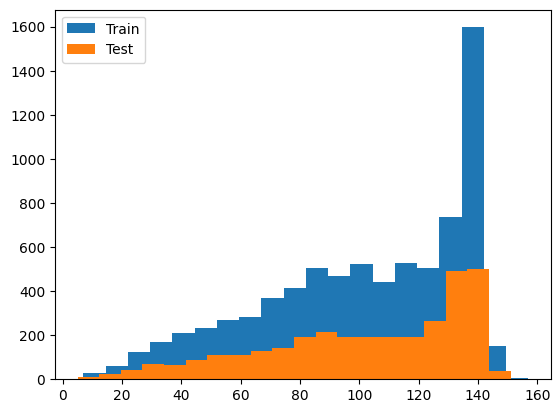

In [ ]:
plt.hist(df_train["length"], bins=20, label="Train")
plt.hist(df_test["length"], bins=20, label="Test")
plt.legend()
plt.show()

### Split the training dataset into 80% training and 20% validation sets

But first we will clean up the tweets, lower case, remove html characters, remove non-ascii characters, only keep words and space

In [ ]:
import re
import sys
import html
import pprint
def clean_text(text):
    text = text.lower()
    text = html.unescape(text)
    encoded_text = text.encode('ascii', errors='ignore')
    text = encoded_text.decode()
    text = re.sub(r'[^\w\s]', '', text)
    return text
df_train["text"] = df_train["text"].apply(clean_text)
df_test["text"] = df_test["text"].apply(clean_text)
df_train["text"].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

X_test = df_test["text"]
print(X_train.shape, X_val.shape, X_test.shape)

(6090,) (1523,) (3263,)


In [ ]:
X_train.head()

1163    sioux city fire officials believe bridge colla...
4989    i strongly support our military  their familie...
6913    lucysforsale funny cause my dumb ass was the y...
6711    usnwsgov special weather statement issued augu...
2736    abcnews  obama declares disaster for typhoonde...
Name: text, dtype: object

### Use pre-trained NLP model DistilBert

The DistilBERT model was proposed in the blog post [Smaller, faster, cheaper, lighter: Introducing DistilBERT, a distilled version of BERT](https://medium.com/huggingface/distilbert-8cf3380435b5), and the paper [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/papers/1910.01108).

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.



### Tokenize the input data using the `DistilBertTokenizer` with the preset `distil_bert_base_en`


In [ ]:
tokenizer = keras_nlp.models.DistilBertTokenizer.from_preset(
    "distil_bert_base_en_uncased",
)


In [ ]:
#encoded_input = tokenizer(X_train.tolist(), truncation=True, padding=True, return_tensors="tf", )
processor= keras_nlp.models.DistilBertPreprocessor(
    tokenizer, sequence_length=140, truncate="round_robin",)
encoded_input = processor(X_train.tolist())
encoded_input_val = processor(X_val.tolist())

In [ ]:
print(encoded_input)

{'token_ids': <tf.Tensor: shape=(6090, 140), dtype=int32, numpy=
array([[  101, 16615,  2103, ...,     0,     0,     0],
       [  101,  1045,  6118, ...,     0,     0,     0],
       [  101,  7004, 22747, ...,     0,     0,     0],
       ...,
       [  101, 19183,  9451, ...,     0,     0,     0],
       [  101,  2074,  3294, ...,     0,     0,     0],
       [  101,  6168, 15333, ...,     0,     0,     0]], dtype=int32)>, 'padding_mask': <tf.Tensor: shape=(6090, 140), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>}


## Build the model

In [ ]:
## Using pre-trained classifier with preset "distil_bert_base_en_uncased"
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=2,
    preprocessor=processor,
)
classifier.summary()

Preprocessor: "distil_bert_preprocessor_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_8 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_8[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=1e-05),
    jit_compile=True,
    metrics=["accuracy"],
)
# Access backbone programmatically (e.g., to change `trainable`).
classifier.backbone.trainable = True
# Fit the model
classifier.fit(x=X_train,
               y=y_train,
               batch_size=32,
               epochs=3,
               validation_data=(X_val, y_val)
               )

Epoch 1/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 117s 323ms/step - accuracy: 0.7177 - loss: 0.5669 - val_accuracy: 0.7879 - val_loss: 0.4857
Epoch 2/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.8495 - loss: 0.3790 - val_accuracy: 0.8089 - val_loss: 0.4739
Epoch 3/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.8775 - loss: 0.3281 - val_accuracy: 0.7971 - val_loss: 0.5265


In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step


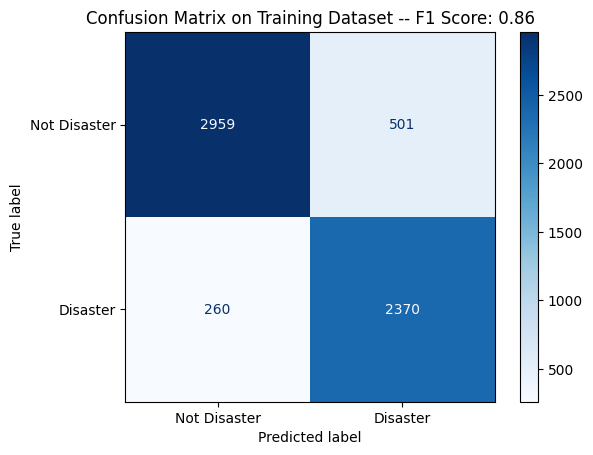

In [ ]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

#### Check the confusion matrix for the Validation dataset

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


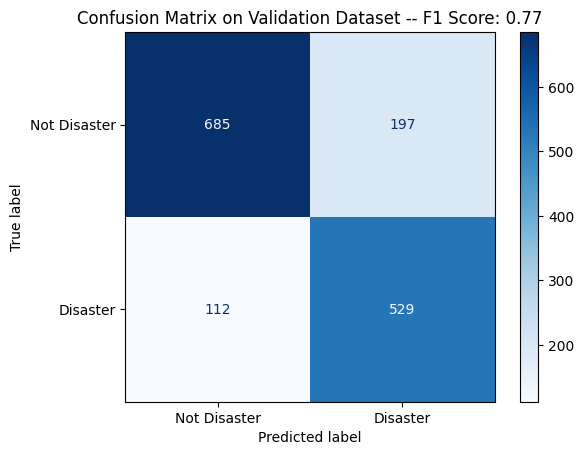

In [ ]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

## Summary
 We see that when we clean the tweets data, we get much better prediction results.

In [ ]:
os.listdir()

['.config',
 'train.csv',
 'nlp-getting-started.zip',
 'test.csv',
 'sample_submission.csv',
 'sample_data']

In [ ]:
#sample_df = pd.read_csv("sample_submission.csv")
df_test.head()

,id,keyword,location,text,length
0,0,NaN,NaN,just happened a terrible car crash,34
1,2,NaN,NaN,heard about earthquake is different cities sta...,64
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,96
3,9,NaN,NaN,apocalypse lighting spokane wildfires,40
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,45


### Predict values for test data and create submission file

In [ ]:
test_results = classifier.predict(X_test)
predictions = np.argmax(test_results, axis=1)
submit_ds = pd.DataFrame({'id': df_test.id,
                          'target': predictions})
submit_ds.to_csv('submission.csv', index=False)
!cp submission.csv '/gdrive/MyDrive/kaggle/'

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step
